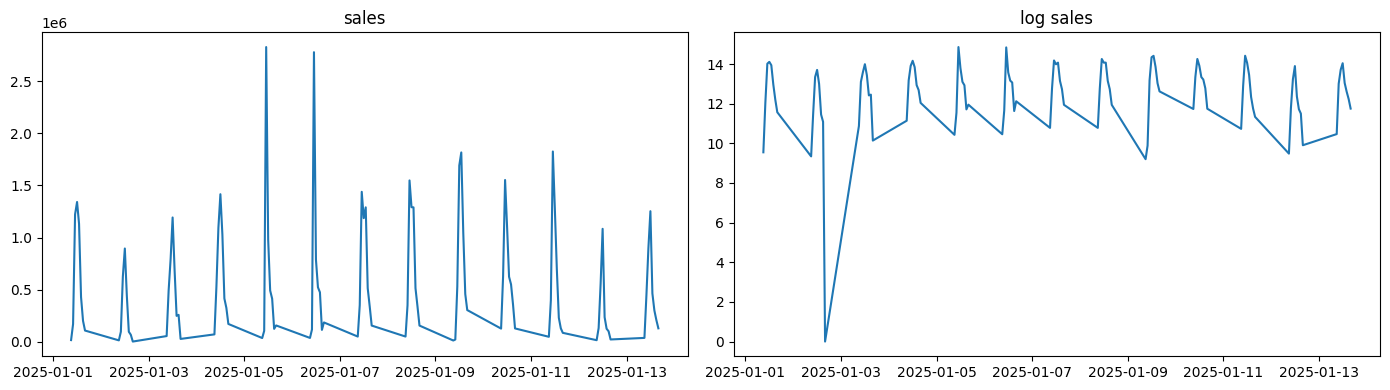

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv("./data/d2.csv", parse_dates=["timestamp"])

df["log_sales"] = np.log(df["sales"])

# 시각화: 원본 vs 로그 변환
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(df["timestamp"], df["sales"])
plt.title("sales")

plt.subplot(1, 2, 2)
plt.plot(df["timestamp"], df["log_sales"])
plt.title("log sales")
plt.tight_layout()
plt.show()


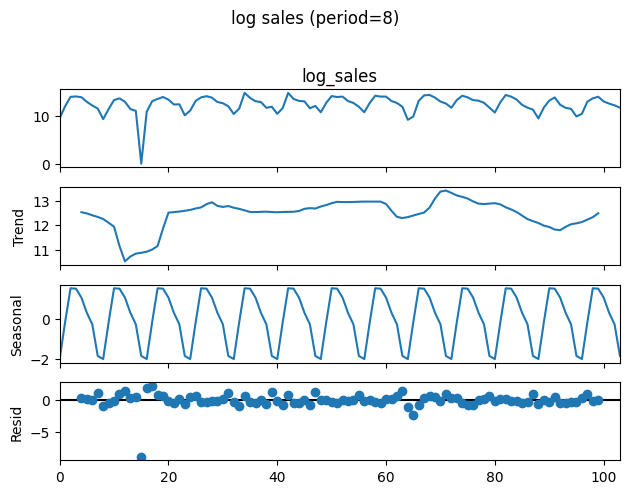

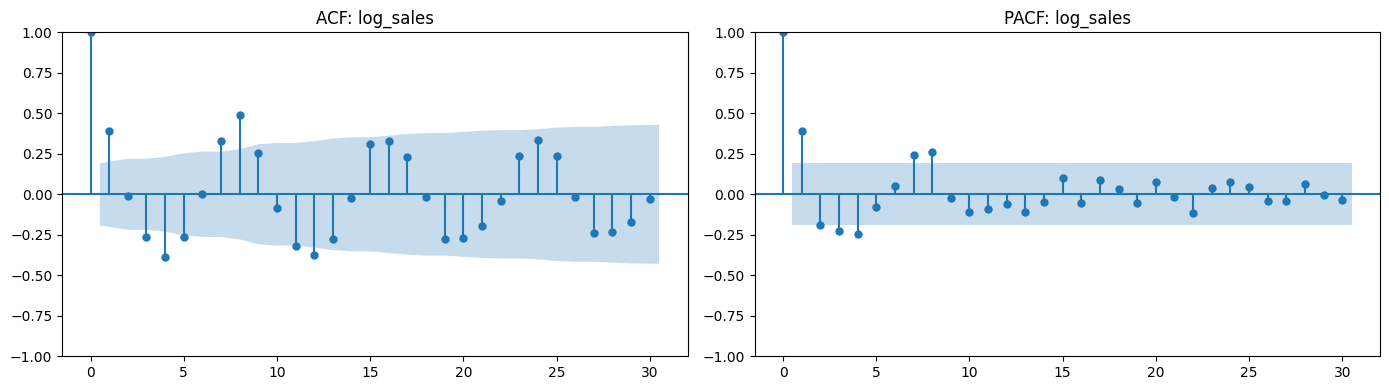

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# log 변환만 적용 (0값은 없음)
df["log_sales"] = np.log(df["sales"])

# 시도표: seasonal_decompose (period=8 가정)
decomp = seasonal_decompose(df["log_sales"], period=8, model="additive")

# 시도표 시각화
decomp.plot()
plt.suptitle("log sales (period=8)", y=1.02)
plt.tight_layout()
plt.show()

# ACF/PACF plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df["log_sales"], lags=30, ax=axes[0])
axes[0].set_title("ACF: log_sales")
plot_pacf(df["log_sales"], lags=30, ax=axes[1])
axes[1].set_title("PACF: log_sales")
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_stationarity_tests(series, name="Series"):
    print(f"📌 정상성 검정 결과 ({name})")

    # ADF
    adf_result = adfuller(series)
    print(f"ADF Test: p-value={adf_result[1]:.4f} → {'정상성 있음' if adf_result[1] < 0.05 else '비정상'}")

    # KPSS
    kpss_result = kpss(series, regression='c', nlags="auto")
    print(f"KPSS Test: p-value={kpss_result[1]:.4f} → {'정상성 있음' if kpss_result[1] > 0.05 else '비정상'}")

# 예시 사용:
run_stationarity_tests(df["log_sales"], name="log_sales")


📌 정상성 검정 결과 (log_sales)
ADF Test: p-value=0.1734 → 비정상
KPSS Test: p-value=0.1000 → 정상성 있음


C:\Users\Lucky\AppData\Local\Temp\ipykernel_7608\1167588767.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


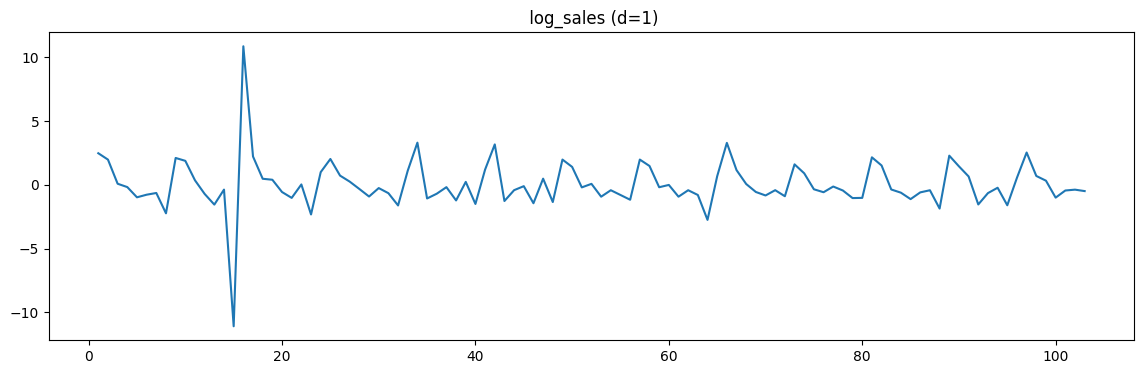

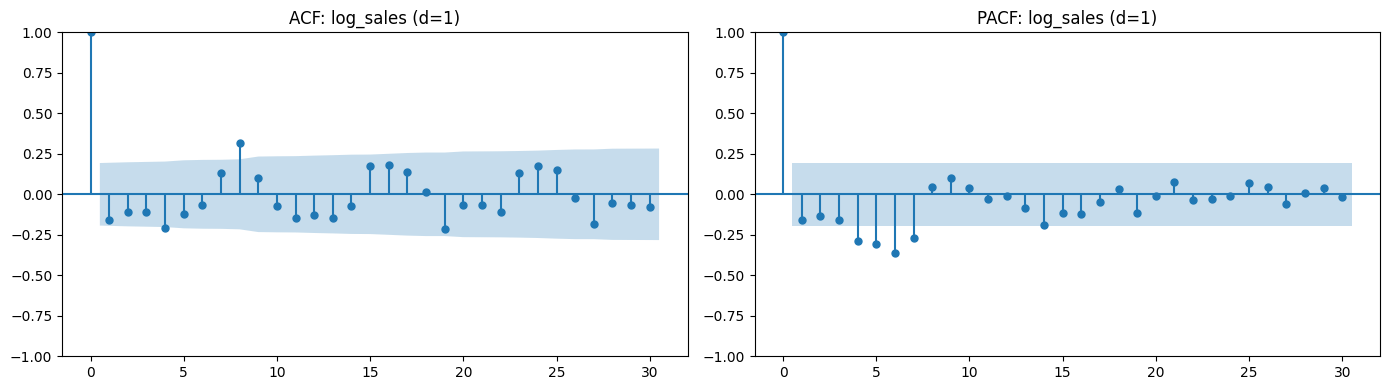

📌 정상성 검정 결과 (1차 차분 log_sales)
ADF Test: p-value=0.0000 → 정상성 있음 ✅
KPSS Test: p-value=0.1000 → 정상성 있음 ✅


C:\Users\Lucky\AppData\Local\Temp\ipykernel_7608\3059062047.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. 1차 차분
log_diff = df["log_sales"].diff().dropna()

# 2. 시각화
plt.figure(figsize=(14, 4))
plt.plot(log_diff)
plt.title(" log_sales (d=1)")
plt.show()

# 3. ACF / PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(log_diff, lags=30, ax=axes[0])
axes[0].set_title("ACF: log_sales (d=1)")
plot_pacf(log_diff, lags=30, ax=axes[1])
axes[1].set_title("PACF: log_sales (d=1)")
plt.tight_layout()
plt.show()

# 4. ADF / KPSS
def run_stationarity_tests(series, name="Series"):
    print(f"📌 정상성 검정 결과 ({name})")

    # ADF
    adf_result = adfuller(series)
    print(f"ADF Test: p-value={adf_result[1]:.4f} → {'정상성 있음 ✅' if adf_result[1] < 0.05 else '비정상 ❌'}")

    # KPSS
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Test: p-value={kpss_result[1]:.4f} → {'정상성 있음 ✅' if kpss_result[1] > 0.05 else '비정상 ❌'}")

run_stationarity_tests(log_diff, name="1차 차분 log_sales")


In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# 1. 원본 보정 데이터 (1 포함)
log_sales = df["log_sales"].copy()
train_1 = log_sales[:-8]
test_1 = log_sales[-8:]

# 2. 1 제거된 데이터
df_clean = df[df["sales"] != 1].copy()
log_sales_clean = np.log(df_clean["sales"])
train_2 = log_sales_clean[:-8]
test_2 = log_sales_clean[-8:]

# 3. 공통 모델 파라미터 (예: SARIMA(1,1,1)(1,1,0)[8])
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 8)

# Case 1 - 보정값 포함
model_1 = SARIMAX(train_1, order=order, seasonal_order=seasonal_order)
result_1 = model_1.fit(disp=False)
forecast_1 = result_1.forecast(steps=8)

# Case 2 - 보정값 제거
model_2 = SARIMAX(train_2, order=order, seasonal_order=seasonal_order)
result_2 = model_2.fit(disp=False)
forecast_2 = result_2.forecast(steps=8)

# 4. 역변환 (exp) → 원래 단위로
true_1 = np.exp(test_1)
true_2 = np.exp(test_2)
pred_1 = np.exp(forecast_1)
pred_2 = np.exp(forecast_2)

# 5. 성능 비교
print("✅ 예측 비교 결과 (sales=1 포함 vs 제거)\n")
print("▶ Case 1 (보정 포함)")
print(f"MAE: {mean_absolute_error(true_1, pred_1):,.0f}")
print(f"MAPE: {mean_absolute_percentage_error(true_1, pred_1):.2%}")

print("\n▶ Case 2 (보정 제거)")
print(f"MAE: {mean_absolute_error(true_2, pred_2):,.0f}")
print(f"MAPE: {mean_absolute_percentage_error(true_2, pred_2):.2%}")


✅ 예측 비교 결과 (sales=1 포함 vs 제거)

▶ Case 1 (보정 포함)
MAE: 159,399
MAPE: 46.37%

▶ Case 2 (보정 제거)
MAE: 215,621
MAPE: 58.93%


C:\Users\Lucky\anaconda3\envs\covid-forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Lucky\anaconda3\envs\covid-forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Lucky\anaconda3\envs\covid-forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lucky\anaconda3\envs\covid-forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index

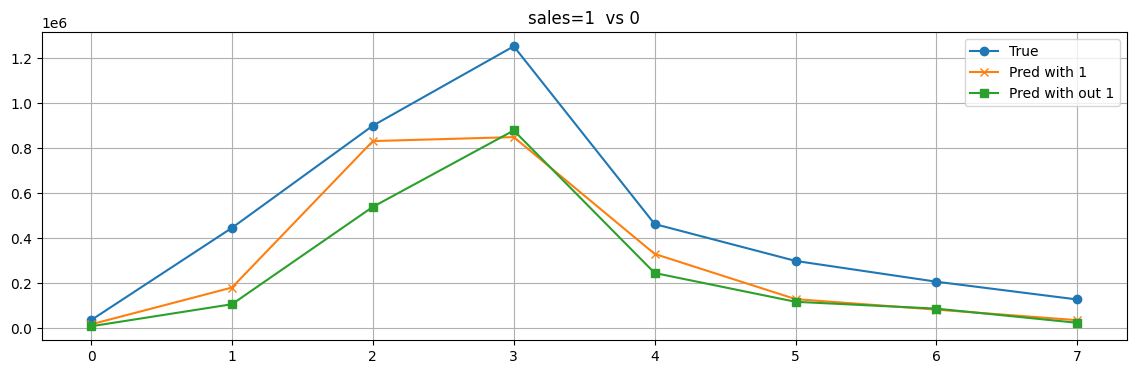

In [17]:
plt.figure(figsize=(14,4))
plt.plot(true_1.values, label="True", marker='o')
plt.plot(pred_1.values, label="Pred with 1", marker='x')
plt.plot(pred_2.values, label="Pred with out 1", marker='s')
plt.title("sales=1  vs 0")
plt.legend()
plt.grid(True)
plt.show()


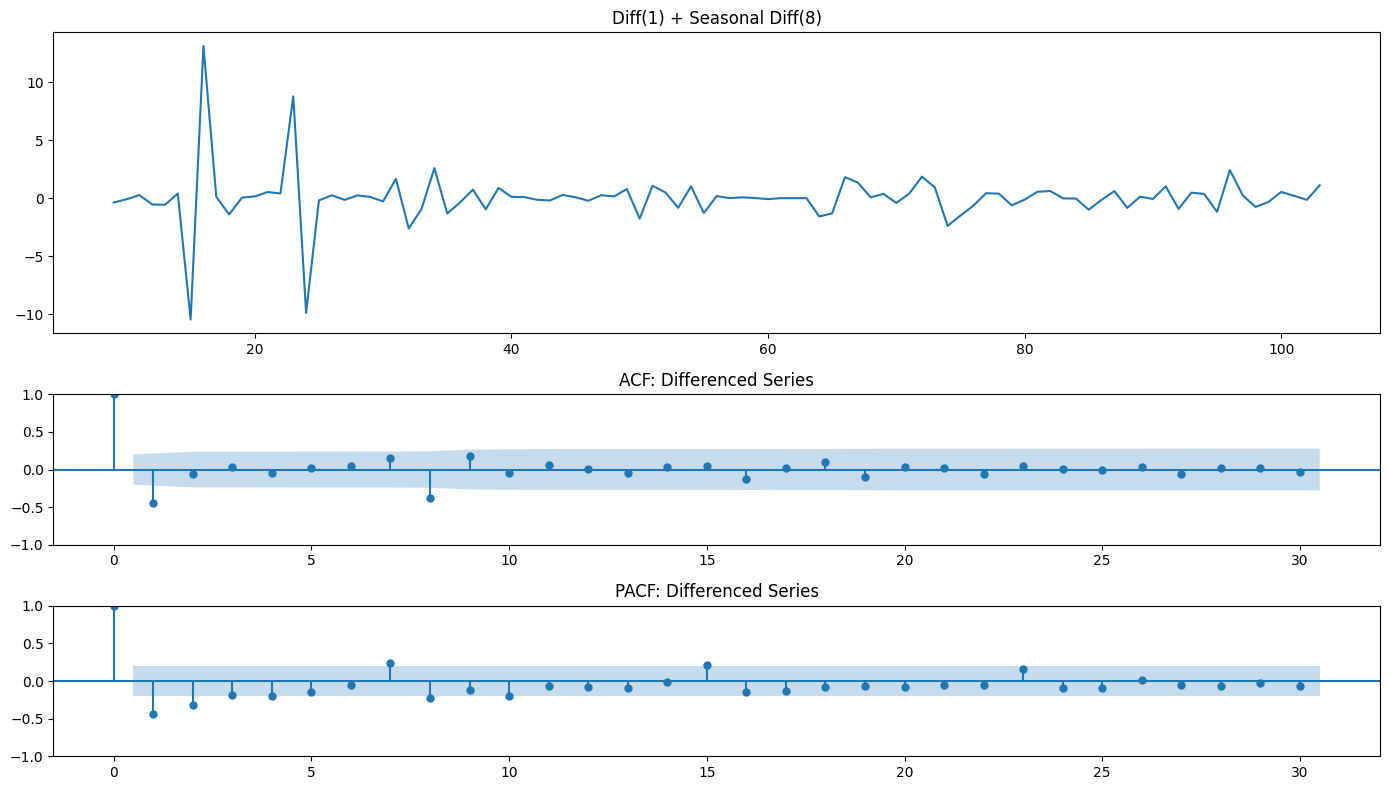

{'ADF': {'statistic': np.float64(-5.15), 'p-value': np.float64(0.0)},
 'KPSS': {'statistic': np.float64(0.5), 'p-value': np.float64(0.0417)}}

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 사용자 지정: 계절 차분 주기 24로 설정
df["log_sales_diff1"] = df["log_sales"].diff()
df["log_sales_diff1_seasonal"] = df["log_sales_diff1"].diff(8)

# 결측 제거
final_diff = df["log_sales_diff1_seasonal"].dropna()

# 정상성 검정
adf_result = adfuller(final_diff)
kpss_result = kpss(final_diff, regression='c', nlags="auto")

# 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 8), gridspec_kw={"height_ratios": [2, 1, 1]})

axes[0].plot(final_diff)
axes[0].set_title("Diff(1) + Seasonal Diff(8)")

plot_acf(final_diff, lags=30, ax=axes[1])
axes[1].set_title("ACF: Differenced Series")

plot_pacf(final_diff, lags=30, ax=axes[2])
axes[2].set_title("PACF: Differenced Series")

plt.tight_layout()
plt.show()

# 출력 결과 (소수 둘째 자리 반올림)
{
    "ADF": {"statistic": round(adf_result[0], 2), "p-value": round(adf_result[1], 4)},
    "KPSS": {"statistic": round(kpss_result[0], 2), "p-value": round(kpss_result[1], 4)}
}


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import itertools
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# 학습/테스트 분리
train_size = int(len(df) * 0.8)
train = df["log_sales"][:train_size]
test = df["log_sales"][train_size:]

# 파라미터 후보 설정 (교수님 ACF/PACF 해석 기반)
p = q = [0, 1]
P = Q = [0, 1]
d = 1
D = 1
m = 8

results = []

# 모든 조합 생성
param_combinations = list(itertools.product(p, q, P, Q))

for (p_, q_, P_, Q_) in param_combinations:
    try:
        model = SARIMAX(train,
                        order=(p_, d, q_),
                        seasonal_order=(P_, D, Q_, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted = model.fit(disp=False)
        forecast = fitted.forecast(steps=len(test))

        mape = mean_absolute_percentage_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        results.append({
            "p": p_, "q": q_, "P": P_, "Q": Q_,
            "AIC": round(fitted.aic, 2),
            "MAPE": round(mape * 100, 2),
            "RMSE": round(rmse, 2)
        })

    except Exception as e:
        print(f"Error with params {(p_, q_, P_, Q_)}: {e}")
        continue

results_df = pd.DataFrame(results).sort_values("AIC")

print(results_df)


    p  q  P  Q     AIC   MAPE  RMSE
15  1  1  1  1  208.96   7.73  1.07
13  1  1  0  1  210.26   9.40  1.24
5   0  1  0  1  210.62   8.85  1.18
7   0  1  1  1  214.59   6.76  0.97
14  1  1  1  0  222.12   9.84  1.28
9   1  0  0  1  224.97  11.25  1.45
6   0  1  1  0  225.30   9.56  1.25
11  1  0  1  1  227.36   5.30  0.72
3   0  0  1  1  229.63   4.86  0.67
1   0  0  0  1  233.10  10.57  1.38
10  1  0  1  0  239.39  15.45  1.93
2   0  0  1  0  249.44  14.36  1.80
4   0  1  0  0  314.48   6.29  0.91
12  1  1  0  0  314.78   6.28  0.91
8   1  0  0  0  337.20   5.83  0.84
0   0  0  0  0  351.45   8.05  1.10


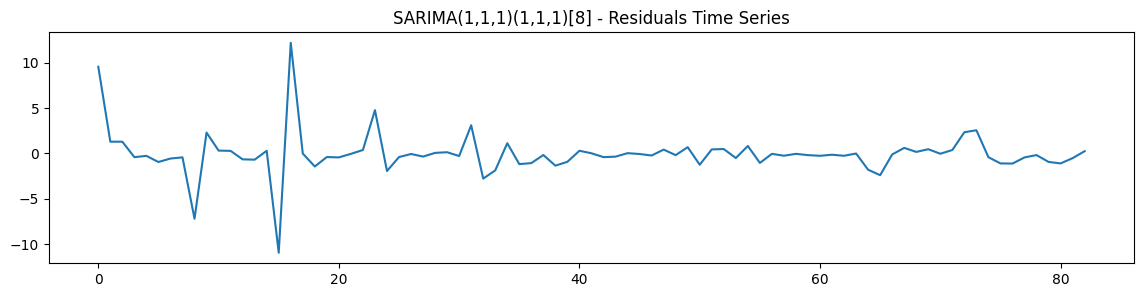

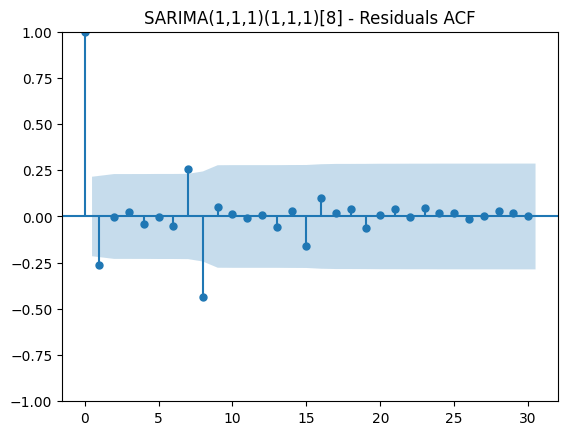

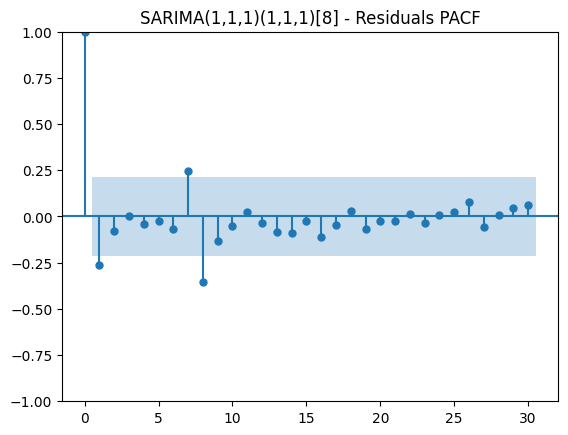

SARIMA(1,1,1)(1,1,1)[8] - Ljung-Box Test:
       lb_stat  lb_pvalue
10  30.777061   0.000639
15  33.860020   0.003563
20  35.592850   0.017165 



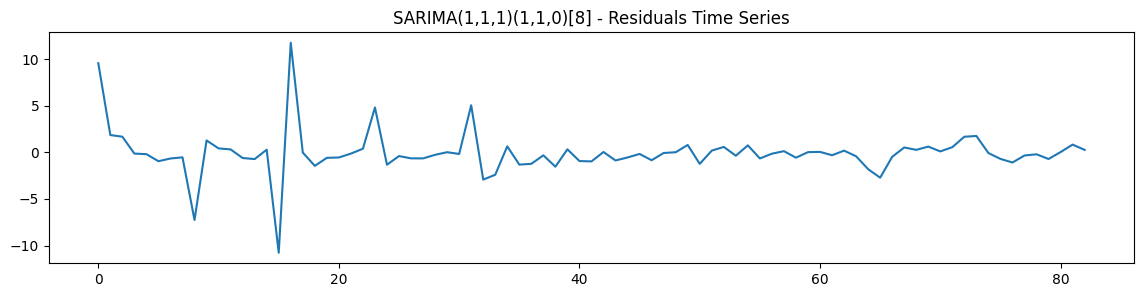

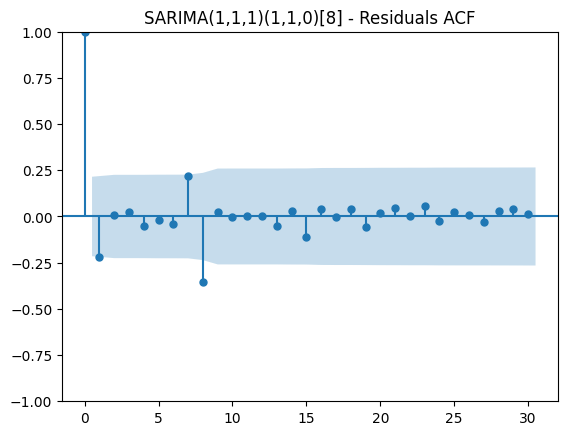

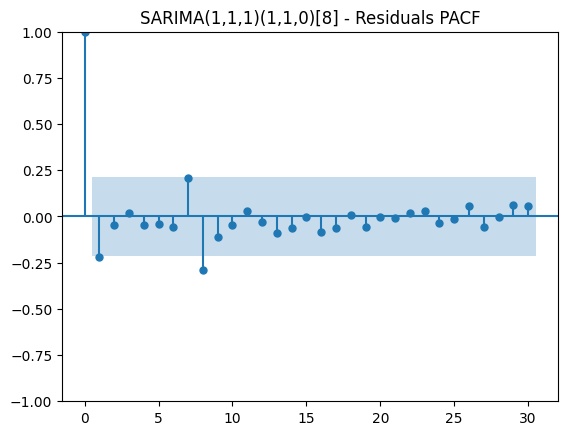

SARIMA(1,1,1)(1,1,0)[8] - Ljung-Box Test:
       lb_stat  lb_pvalue
10  20.936686   0.021539
15  22.576677   0.093551
20  23.336200   0.272589 



In [39]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import numpy as np

# 모델 후보 리스트
candidate_models = {
    "SARIMA(1,1,1)(1,1,1)[8]": (1, 1, 1, 1),
    "SARIMA(1,1,1)(1,1,0)[8]": (1, 1, 1, 0)
}

results = {}

for name, (p, q, P, Q) in candidate_models.items():
    model = SARIMAX(train,
                    order=(p, 1, q),
                    seasonal_order=(P, 1, Q, 8),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted = model.fit(disp=False)
    residuals = fitted.resid

    # Ljung-Box 검정
    lb_test = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)

    # 예측
    forecast = fitted.forecast(steps=len(test))
    mape = mean_absolute_percentage_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    results[name] = {
        "residuals": residuals,
        "lb_test": lb_test,
        "mape": mape,
        "rmse": rmse,
        "forecast": forecast,
        "model": fitted
    }

    # 잔차 시계열 플롯
    plt.figure(figsize=(14, 3))
    plt.plot(residuals)
    plt.title(f"{name} - Residuals Time Series")
    plt.show()

    # 잔차 ACF 플롯
    plot_acf(residuals, lags=30)
    plt.title(f"{name} - Residuals ACF")
    plt.show()
   

    # 기존 코드 내 plot_acf 아래에 추가
    plot_pacf(residuals, lags=30)
    plt.title(f"{name} - Residuals PACF")
    plt.show()


    print(f"{name} - Ljung-Box Test:\n", lb_test, "\n")

# 잔차분석 결과 확인 후 모델 비교 및 최종 선택 가능


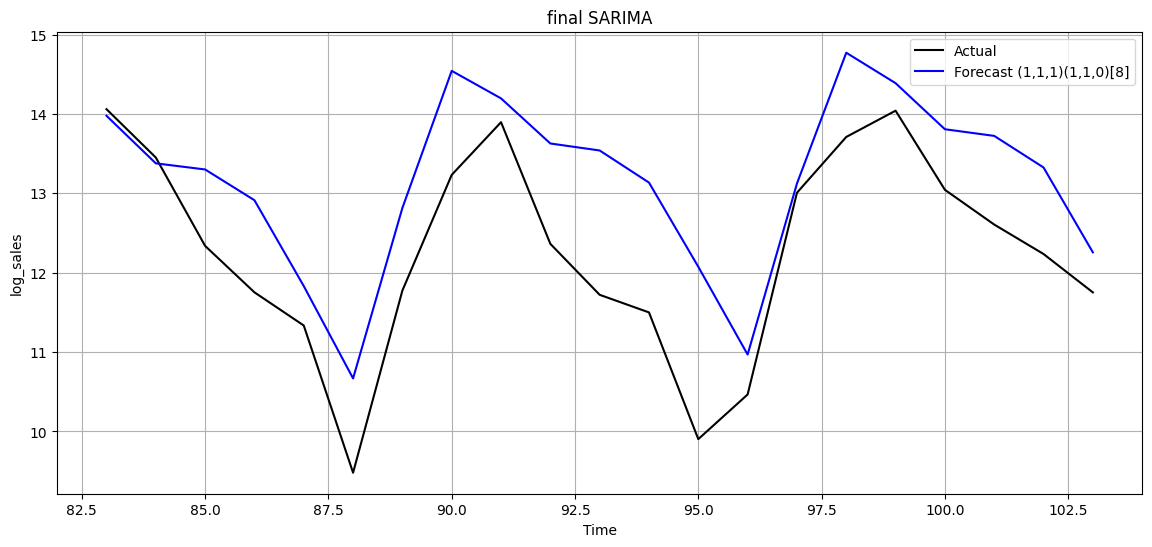

In [41]:
import matplotlib.pyplot as plt

# 최종 모델 학습 및 예측
final_model = SARIMAX(train,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 8),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_result = final_model.fit(disp=False)

forecast = final_result.forecast(steps=len(test))

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='Forecast (1,1,1)(1,1,0)[8]', color='blue')
plt.title('final SARIMA')
plt.xlabel('Time')
plt.ylabel('log_sales')
plt.legend()
plt.grid(True)
plt.show()


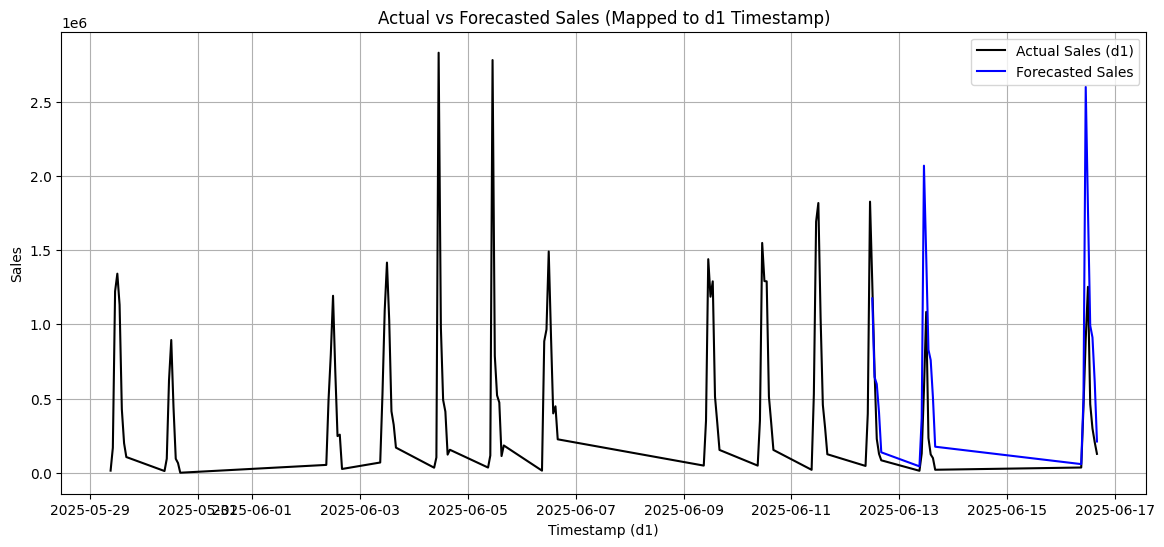

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) d1, d2 데이터 불러오기
df_d1 = pd.read_csv('./data/d1.csv', parse_dates=['timestamp_d1'])
df_d2 = pd.read_csv('./data/d2.csv', parse_dates=['timestamp'])

# 2) 최종 SARIMA 예측 결과 (log scale)
forecast_log = final_result.forecast(steps=len(test))

# 3) d2의 test 기간 timestamp 추출
test_timestamps_d2 = df_d2['timestamp'].iloc[-len(test):].reset_index(drop=True)

# 4) 예측 결과 DataFrame 생성
df_forecast = pd.DataFrame({
    'timestamp_d2': test_timestamps_d2,
    'forecast_log_sales': forecast_log.values
})

# 5) 매핑 테이블 생성 및 병합
mapping_table = pd.DataFrame({
    'timestamp_d2': df_d2['timestamp'].values,
    'timestamp_d1': df_d1['timestamp_d1'].iloc[:len(df_d2)].values
})

df_forecast = df_forecast.merge(mapping_table, on='timestamp_d2', how='left')

# 6) 실제 d1 timestamp 기준 정렬
df_forecast_sorted = df_forecast.sort_values('timestamp_d1').reset_index(drop=True)

# 7) 예측 로그 역변환
df_forecast_sorted['forecast_sales'] = np.exp(df_forecast_sorted['forecast_log_sales'])

# 8) 시각화: 실제 d1 매출과 예측값 비교
plt.figure(figsize=(14, 6))
plt.plot(df_d1['timestamp_d1'], df_d1['sales'], label='Actual Sales (d1)', color='black')
plt.plot(df_forecast_sorted['timestamp_d1'], df_forecast_sorted['forecast_sales'], label='Forecasted Sales', color='blue')
plt.xlabel('Timestamp (d1)')
plt.ylabel('Sales')
plt.title('Actual vs Forecasted Sales (Mapped to d1 Timestamp)')
plt.legend()
plt.grid(True)
plt.show()
